# Aufgabe 09 - Monte Carlo Methods
10.01.2022, Thomas Iten


**Content**
0. Setup
1. Explore Blackjack Environment
2. Limit Stochastic Methode
3. Monte Carlo Prediction
4. Monte Carlo Control

**References**
- https://colab.research.google.com/drive/1YGC4e4Zrazn5rk76dETaDk5utsI5XFCz
- https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
- https://github.com/udacity/deep-reinforcement-learning/tree/master/monte-carlo
- https://s3-us-west-1.amazonaws.com/udacity-drlnd/bookdraft2018.pdf
- https://www.katnoria.com/nb_montecarlo/

## 0. Setup

### Imports

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Plot utils

In [2]:
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


## 1. Explore Blackjack Environment

### Black Jack environment

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [3]:
env = gym.make('Blackjack-v1')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 11\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:
```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Play random policy

Execute the code cell below to play Blackjack with a random policy.  
- The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.
- The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [5]:
for i_episode in range(3):
    print("#")
    print("# Game", i_episode+1)
    print("#")

    state = env.reset()
    print("State :", state)
    while True:
        action = env.action_space.sample()
        print("Action:", action)
        state, reward, done, info = env.step(action)
        print("State :", state, "- Reward:", reward, "- Done:", done, "- Info:", info)
        if done:
            if reward > 0:
                print('End game: you won :-)')
            else:
                print('End game: you lost :-(')
            break

#
# Game 1
#
State : (16, 3, False)
Action: 1
State : (24, 3, False) - Reward: -1.0 - Done: True - Info: {}
End game: you lost :-(
#
# Game 2
#
State : (12, 4, False)
Action: 0
State : (12, 4, False) - Reward: 1.0 - Done: True - Info: {}
End game: you won :-)
#
# Game 3
#
State : (12, 6, False)
Action: 0
State : (12, 6, False) - Reward: 1.0 - Done: True - Info: {}
End game: you won :-)


## 2. Limit Stochastic Methode

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).
We will begin by investigating a policy where the player **almost** always sticks if the sum of her cards exceeds 18.
- If sum > 18 : select action `STICK` with 80% probability
- If sum <= 18: selects action `HIT` with 80% probability.


### Define generate_episode_from_limit_stochastic methode

The function **generate_episode_from_limit_stochastic** samples an episode using this policy.
- Input : `bj_env`: This is an instance of OpenAI Gym's Blackjack environment
- Output: `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to:
  - $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.
  - In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$,
  - and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [6]:
# our starting policy
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

### Play generate_episode_from_limit_stochastic

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [7]:
for i in range(3):
    episode = generate_episode_from_limit_stochastic(env)
    print(episode)

[((8, 10, False), 1, 0.0), ((18, 10, False), 0, 1.0)]
[((20, 2, False), 0, 1.0)]
[((11, 5, False), 1, 0.0), ((12, 5, False), 1, 0.0), ((18, 5, False), 0, -1.0)]


## 3. Monte Carlo Prediction


### Define mc_prediction
Now, you are ready to write your own implementation of MC prediction.
- Feel free to implement either first-visit or every-visit MC prediction;
- in the case of the Blackjack environment, the techniques are equivalent.

**Input Arguments:**
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1 inclusive (default value: `0.8`).
- `print_n_episode`: Each n episode will be printed to system out (default value: `1`).

**Return:**
- `Q`: This is a dictionary (of one-dimensional arrays)
- where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [8]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=0.8, print_n_episode=1):

    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        is_print = i_episode == 1 or i_episode % print_n_episode == 0
        if is_print:
            print("# ================================================================")
            print("# Episode {}/{}".format(i_episode, num_episodes))
            print("# ================================================================")
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards))])
        if is_print:
            print("discounts:", discounts)
            print("rewards:", rewards)
            print("states:", states)
            print("------------------------------------------------------------------")
        # update the sum of the returns, number of visits, and action-value
        # function estimates for each state-action pair in the episode
        for i, (state, action) in enumerate(zip(states, actions)):
            n_steps_after_state = len(rewards[i:])
            if is_print:
                print("rewards[i:]:", rewards[i:])
                print("discounts[:n_steps_after_state]:", discounts[:n_steps_after_state])
            returns_sum[state][action] += sum(rewards[i:]*discounts[:n_steps_after_state])
            N[state][action] += 1.0
            Q[state][action] = returns_sum[state][action] / N[state][action]
            if is_print:
                print("Q-Value:", Q[state][action])
                print("State:", state)
                print("Action:", action)
                print("")
    return Q

### Test mc_prediction

Use the cell below to obtain the action-value function estimate $Q$.
We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions
notebook **Monte_Carlo_Solution.ipynb**.

In [9]:
num_episodes = 3
Q = mc_prediction_q(env, num_episodes, generate_episode_from_limit_stochastic)


# ================================================================
# Episode 1/3
# ================================================================
discounts: [1.]
rewards: (-1.0,)
states: ((12, 10, False),)
------------------------------------------------------------------
rewards[i:]: (-1.0,)
discounts[:n_steps_after_state]: [1.]
Q-Value: -1.0
State: (12, 10, False)
Action: 0

# ================================================================
# Episode 2/3
# ================================================================
discounts: [1.]
rewards: (-1.0,)
states: ((20, 9, False),)
------------------------------------------------------------------
rewards[i:]: (-1.0,)
discounts[:n_steps_after_state]: [1.]
Q-Value: -1.0
State: (20, 9, False)
Action: 1

# ================================================================
# Episode 3/3
# ================================================================
discounts: [1.  0.8]
rewards: (0.0, -1.0)
states: ((12, 7, False), (20, 7, False))
-------

In [10]:
test = (9, 6, False)
(test[0] > 18)*5

0

### Play mc_prediction

# ================================================================
# Episode 1/10000
# ================================================================
discounts: [1.   0.8  0.64]
rewards: (0.0, 0.0, -1.0)
states: ((17, 1, True), (18, 1, True), (18, 1, False))
------------------------------------------------------------------
rewards[i:]: (0.0, 0.0, -1.0)
discounts[:n_steps_after_state]: [1.   0.8  0.64]
Q-Value: -0.6400000000000001
State: (17, 1, True)
Action: 1

rewards[i:]: (0.0, -1.0)
discounts[:n_steps_after_state]: [1.  0.8]
Q-Value: -0.8
State: (18, 1, True)
Action: 1

rewards[i:]: (-1.0,)
discounts[:n_steps_after_state]: [1.]
Q-Value: -1.0
State: (18, 1, False)
Action: 1

# ================================================================
# Episode 1000/10000
# ================================================================
discounts: [1.  0.8]
rewards: (0.0, 1.0)
states: ((11, 9, False), (21, 9, False))
------------------------------------------------------------------
rewards

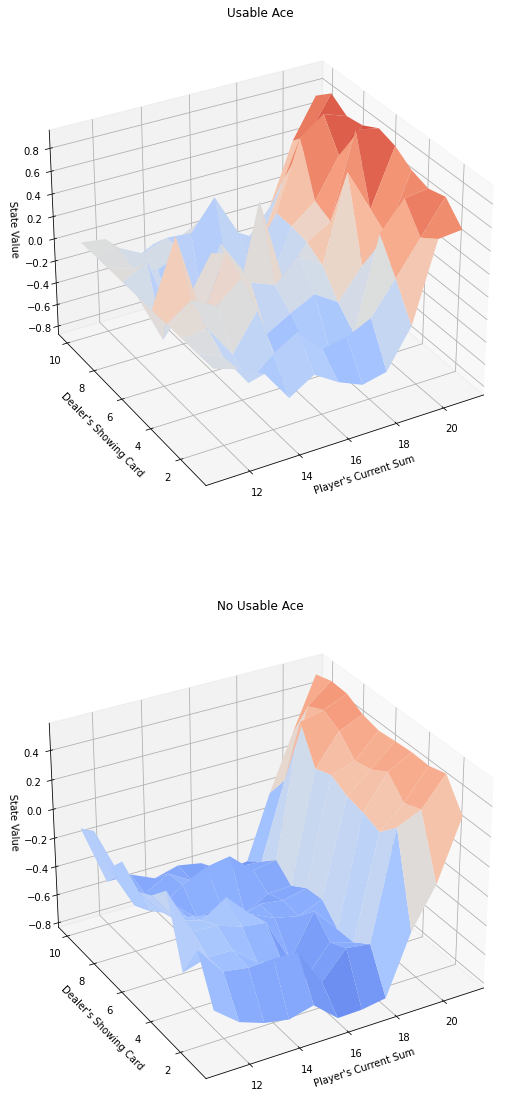

In [11]:
num_episodes = 10000 #500000

# obtain the action-value function
Q = mc_prediction_q(env, num_episodes, generate_episode_from_limit_stochastic, print_n_episode=1000)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

## 4. Monte Carlo Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA): # epsilon greedy
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA # wenn epsilon 1 ist zu Beginn und ich habe 5 Aktionen, dann ist meine Policy [1/5, 1/5,..., 1/5]
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma, is_print): # policy improvement oder control
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        n_steps_after_state = len(rewards[i:])
        old_Q = Q[state][actions[i]] 
        #Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:n_steps_after_state]) - old_Q)
        if is_print:
            print('state:', state)
            print('action:', actions[i])
            print('q-value:', Q[state][actions[i]])
    return Q

In [13]:
def mc_prediction_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05, print_n_episode=1):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        is_print = i_episode == 1 or i_episode % print_n_episode == 0
        if is_print:
            print("# ================================================================")
            print("# Episode {}/{}".format(i_episode, num_episodes))
            print("# ================================================================")
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma, is_print) # prediction und eigentllich control, weil Q table die Vorlage für die nächste Action Selection ist
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items()) # control - Q table wird gelesen
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [14]:
# obtain the estimated optimal policy and action-value function
#policy, Q = mc_prediction_control(env, 500000, 0.02)
policy, Q = mc_prediction_control(env, 10000, 0.02, print_n_episode=1000)

# ================================================================
# Episode 1/10000
# ================================================================
state: (12, 3, False)
action: 0
q-value: -0.02
# ================================================================
# Episode 1000/10000
# ================================================================
state: (9, 10, False)
action: 0
q-value: -0.058808
# ================================================================
# Episode 2000/10000
# ================================================================
state: (21, 9, True)
action: 0
q-value: 0.13187446675328002
# ================================================================
# Episode 3000/10000
# ================================================================
state: (17, 10, False)
action: 1
q-value: -0.5738176690685708
state: (20, 10, False)
action: 1
q-value: -0.6774030635531471
# ================================================================
# Episode 4000/10000
# ===========

In [15]:
policy

{(12, 3, False): 1,
 (21, 2, True): 0,
 (14, 2, False): 0,
 (16, 7, False): 0,
 (19, 6, True): 0,
 (6, 8, False): 1,
 (17, 8, False): 0,
 (16, 10, False): 0,
 (19, 10, False): 0,
 (20, 5, False): 0,
 (20, 8, False): 0,
 (18, 3, False): 0,
 (20, 3, False): 0,
 (14, 4, False): 0,
 (17, 4, False): 0,
 (20, 10, False): 0,
 (19, 2, False): 0,
 (12, 10, False): 0,
 (15, 8, False): 0,
 (17, 2, False): 0,
 (16, 4, False): 0,
 (21, 4, False): 0,
 (15, 10, False): 1,
 (13, 10, False): 0,
 (14, 10, False): 0,
 (21, 9, True): 0,
 (19, 9, False): 0,
 (20, 9, False): 0,
 (17, 7, True): 1,
 (15, 10, True): 1,
 (19, 4, False): 0,
 (19, 10, True): 0,
 (20, 6, False): 0,
 (21, 6, False): 0,
 (11, 9, False): 1,
 (15, 9, False): 0,
 (5, 7, False): 0,
 (8, 7, False): 1,
 (14, 7, False): 0,
 (20, 4, False): 0,
 (13, 4, False): 0,
 (19, 3, True): 0,
 (12, 1, False): 1,
 (15, 8, True): 1,
 (12, 4, False): 0,
 (12, 7, False): 1,
 (20, 1, False): 0,
 (4, 8, False): 0,
 (10, 8, False): 1,
 (14, 1, False): 1,
 (1

Next, we plot the corresponding state-value function.

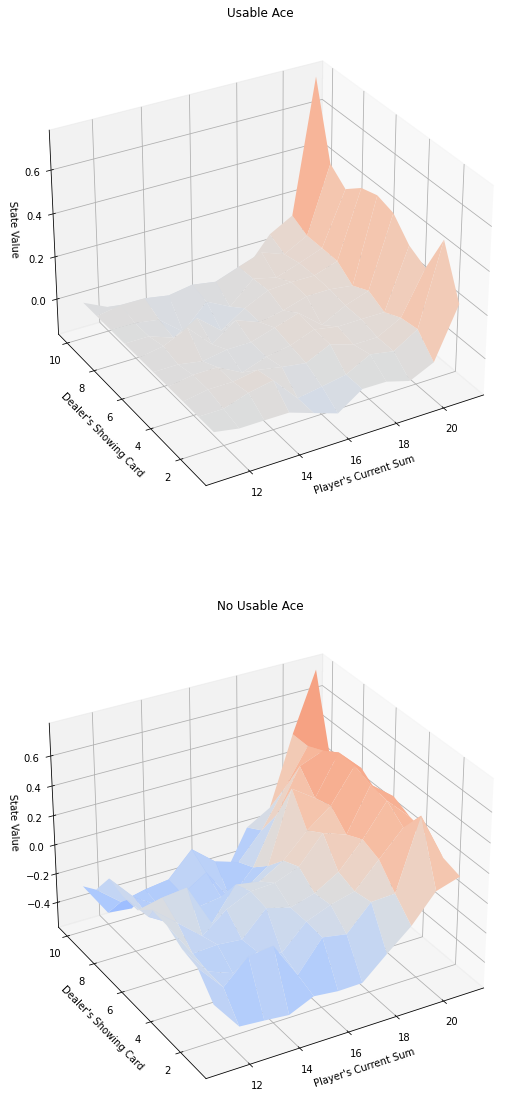

In [16]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

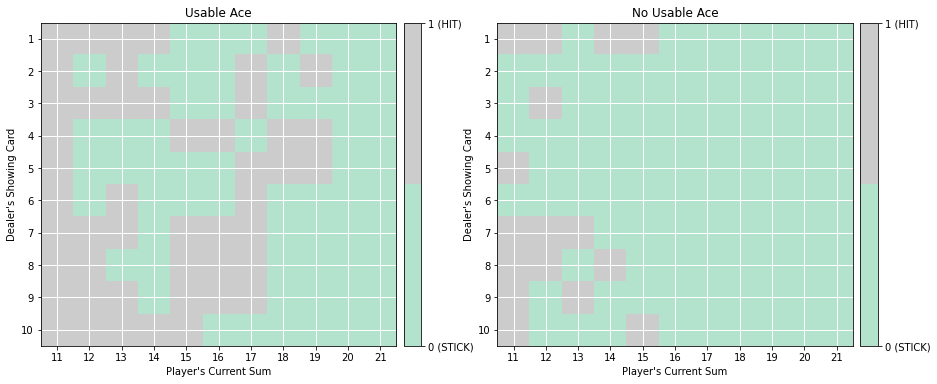

In [17]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of
the [textbook](http://go.udacity.com/rl-textbook) (and appears below).
Compare your final estimate to the optimal policy - how close are you able to get?
If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

---
__The end.__